## Importing Required Packages

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
import os

## Downloading the Dataset

In [2]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = keras.utils.get_file(fname="stackoverflow", origin=url, untar=True, cache_dir=".", cache_subdir="")

6053168/6053168 [==============================] - 1s 0us/step


## Organizing Files in Train and Test Directories

In [3]:
train_dir = "./train"
test_dir = "./test"

In [4]:
!rm README.md stackoverflow.tar.gz

## Opening a Sample File

In [5]:
sample_file = os.path.join(test_dir, "javascript", "564.txt")
with open(sample_file, mode="r+") as file:
  a = file.read()
a

'"passing object in arrow-function in blank i have a really hard time understanding the workflow of the following code-snippet..const circuit = require(\'circuit-sdk\');.const client = new circuit.client({.  client_id: \'&lt;client_id&gt;\',.  client_secret: \'&lt;client_secret&gt;\',.  domain: \'circuitsandbox.net\'.});.client.logon().  .then(user =&gt; console.log(\'logged on as bot: \' + user.emailaddress)).  .catch(console.error);...how is, in the second last line, the object user defined? or, asked another way, how can i access user.emailaddress, without defining it beforehand?..this code works, its a sample from the documetation, i just can\'t get it into my head"\n'

## Building Generators

In [6]:
batch_size = 64
seed = 6

raw_train_ds = keras.utils.text_dataset_from_directory(train_dir,
                                                       batch_size=batch_size,
                                                       validation_split=0.2,
                                                       subset="training",
                                                       seed=seed)

raw_validation_ds = keras.utils.text_dataset_from_directory(train_dir,
                                                            batch_size=batch_size,
                                                            validation_split=0.2,
                                                            subset="validation",
                                                            seed=seed)

raw_test_ds = keras.utils.text_dataset_from_directory(test_dir,
                                                      batch_size=batch_size)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Found 8000 files belonging to 4 classes.
Using 1600 files for validation.
Found 8000 files belonging to 4 classes.


## Defining Text Encoder

In [7]:
vocab_size = 5000

encoder = keras.layers.TextVectorization(max_tokens=vocab_size)
encoder.adapt(raw_train_ds.map(lambda text, label: text))

In [8]:
def vectorize_text(text, label):
  return encoder(text), label

## Mapping the Encoder to the Raw Datasets

In [9]:
train_ds = raw_train_ds.map(vectorize_text)
validation_ds = raw_validation_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

## Configuring the Dataset for Performance

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Creating the Model

In [28]:
model = Sequential([layers.Embedding(vocab_size, 64),
                    layers.Dropout(0.2),
                    layers.GlobalAveragePooling1D(),
                    layers.Dropout(0.2),
                    layers.Dense(4)])

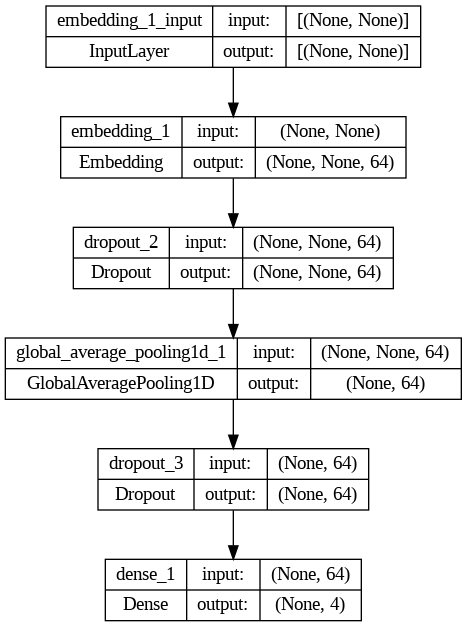

In [29]:
keras.utils.plot_model(model, show_shapes=True)

## Compiling the Model

In [30]:
model.compile(optimizer="adam",
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

## Fitting the Model

In [31]:
history = model.fit(train_ds, validation_data=validation_ds, epochs=50)

Epoch 1/50
100/100 [==============================] - 9s 84ms/step - loss: 1.3819 - accuracy: 0.3250 - val_loss: 1.3764 - val_accuracy: 0.3644
Epoch 2/50
100/100 [==============================] - 0s 5ms/step - loss: 1.3675 - accuracy: 0.4175 - val_loss: 1.3599 - val_accuracy: 0.4281
Epoch 3/50
100/100 [==============================] - 0s 4ms/step - loss: 1.3429 - accuracy: 0.4775 - val_loss: 1.3336 - val_accuracy: 0.4956
Epoch 4/50
100/100 [==============================] - 0s 4ms/step - loss: 1.3074 - accuracy: 0.5283 - val_loss: 1.2981 - val_accuracy: 0.5362
Epoch 5/50
100/100 [==============================] - 0s 4ms/step - loss: 1.2609 - accuracy: 0.5709 - val_loss: 1.2554 - val_accuracy: 0.5731
Epoch 6/50
100/100 [==============================] - 0s 4ms/step - loss: 1.2070 - accuracy: 0.6109 - val_loss: 1.2088 - val_accuracy: 0.6156
Epoch 7/50
100/100 [==============================] - 0s 4ms/step - loss: 1.1496 - accuracy: 0.6466 - val_loss: 1.1603 - val_accuracy: 0.6425
Epoch

## Evaluating the Model

In [37]:
model.evaluate(test_ds)

125/125 [==============================] - 0s 3ms/step - loss: 0.5713 - accuracy: 0.7977


[0.5713008046150208, 0.7977499961853027]

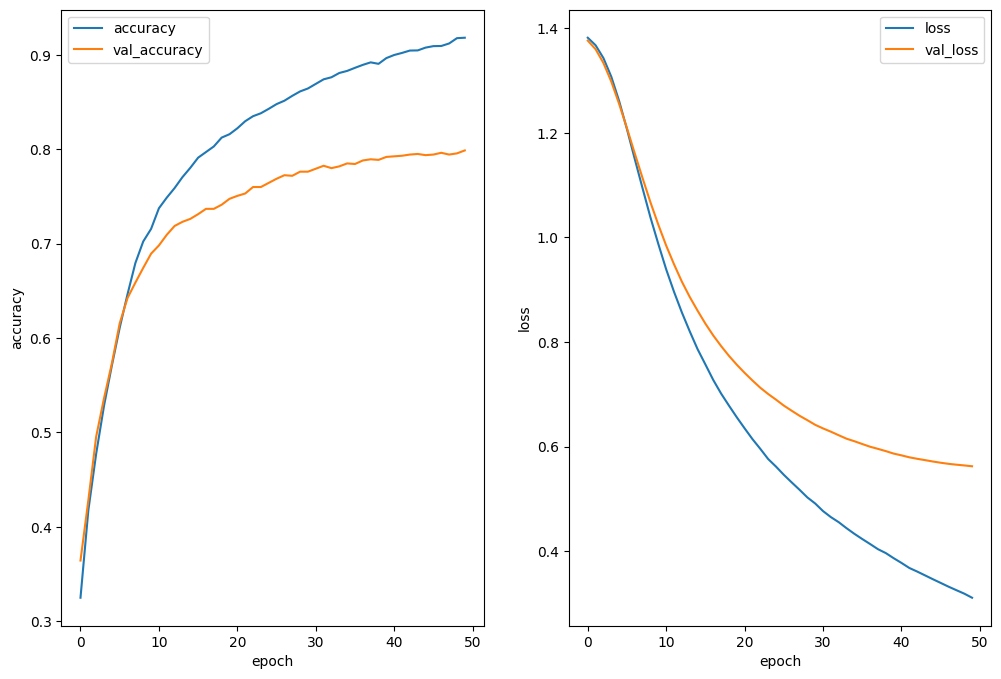

In [38]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(loc="best")
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc="best")
plt.show()

In [52]:
export_model = Sequential([encoder,
                           model,
                           layers.Activation("softmax")])
export_model.compile(optimizer="adam",
                     loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                     metrics=["accuracy"])
export_model.evaluate(raw_test_ds)

125/125 [==============================] - 1s 8ms/step - loss: 0.5727 - accuracy: 0.7979


[0.5726889967918396, 0.7978749871253967]

In [53]:
classes = np.argmax(export_model.predict(["const array =",
                                          "def place_piece(board, x, y, player):",
                                          "void main(string[] args)",
                                          "private vector3 p_pos = new vector3(0, 0, 0);"],
                                         verbose=0), axis=-1)
predictions = [raw_train_ds.class_names[class_] for class_ in classes]
print(predictions)

['javascript', 'python', 'java', 'csharp']
